In [2]:
import os
import sys

sys.path.append("..")

import warnings
warnings.filterwarnings("ignore")

import lpips
import pytorch_lightning as pl

from autoencoder import CIFAR10VAE
from utils import visualize_cifar_reconstructions
from dataloader import load_cifar, load_celeba, load_fashion_mnist, load_mnist

/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/pl_bolts/callbacks/data_monitor.py:20: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/swet

#### Training CIFAR10 Vanilla Autoencoder

In [3]:
loss_fn = lpips.LPIPS(net='vgg')

# from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
# loss_fn = LearnedPerceptualImagePatchSimilarity(net_type='vgg', normalize=True)

train_dataloader, valid_dataloader, test_dataloader = load_cifar(
    root="~/scratch/datasets/CIFAR10/", batch_size=128
)

model = CIFAR10Autoencoder(perceptual_loss=True, loss=loss_fn)
trainer = pl.Trainer(max_epochs=100, accelerator="mps", default_root_dir="..")
trainer.fit(model, train_dataloader, valid_dataloader)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 364 K 
1 | decoder | Sequential | 365 K 
2 | loss    | LPIPS      | 14.7 M
---------------------------------------
731 K     Trainable params
14.7 M    Non-trainable params
15.4 M    Total params
61.787    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

#### Testing CIFAR10 Vanilla Autoencoder

Files already downloaded and verified
Files already downloaded and verified


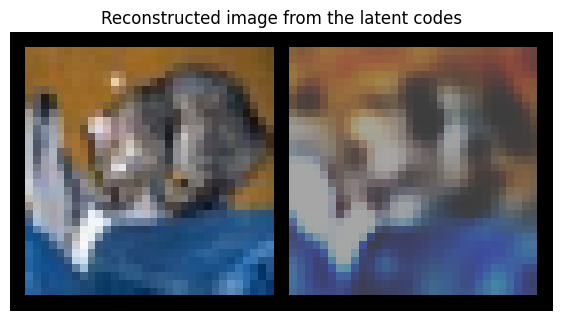

In [4]:
train_dataloader, valid_dataloader, test_dataloader = load_cifar(
    root="~/scratch/datasets/CIFAR10/", batch_size=1
)
input_imgs, _ = next(iter(test_dataloader))
model = CIFAR10Autoencoder.load_from_checkpoint("../lightning_logs/version_36/checkpoints/checkpoint.ckpt")
model.eval()
reconst_imgs, _ = model(input_imgs)

visualize_cifar_reconstructions(input_imgs, reconst_imgs, file_name="cifar10_ae_mse")

In [8]:
loss_fn = lpips.LPIPS(net='vgg')
loss_fn(input_imgs, reconst_imgs)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


tensor([[[[0.2107]]]], grad_fn=<AddBackward0>)

#### Training CIFAR10 VAE

In [7]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

vae = CIFAR10VAE()
train_dataloader, valid_dataloader, test_dataloader = load_cifar(
    root="~/scratch/datasets/CIFAR10/", batch_size=128
)

trainer = pl.Trainer(default_root_dir=os.path.join("..", f"cifar10_vae_256"), 
                     accelerator="mps",
                     devices=1,
                     max_epochs=500, 
                     callbacks=[ModelCheckpoint(save_weights_only=True),
                                LearningRateMonitor("epoch")]
                    )

Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(vae, train_dataloader)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_25080/3695794138.py", line 1, in <cell line: 1>
    trainer.fit(vae, train_dataloader, valid_dataloader)
  File "/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py", line 768, in fit
    datamodule: An instance of :class:`~pytorch_lightning.core.datamodule.LightningDataModule`.
  File "/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py", line 721, in _call_and_handle_interrupt
    "`model` must be provided to `trainer.validate()` when it hasn't been passed in a previous run"
  File "/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py", line 806, in _fit_impl
    # If you supply a da

In [ ]:
encoder = nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=2, padding=1),
    nn.ReLU(True),
    nn.Conv2d(8, 16, 3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    nn.Conv2d(16, 32, 3, stride=2, padding=0),
    nn.ReLU(True),
    nn.Flatten(start_dim=1),
    nn.Linear(3 * 3 * 32, 128),
    nn.ReLU(True),
    nn.Linear(128, 64)
)
decoder = nn.Sequential(
    nn.Linear(64, 128),
    nn.ReLU(True),
    nn.Linear(128, 3 * 3 * 32),
    nn.ReLU(True),
    nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3)),
    nn.ConvTranspose2d(32, 16, 3, 
        stride=2, output_padding=0),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    nn.ConvTranspose2d(16, 8, 3, stride=2, 
        padding=1, output_padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(True),
    nn.ConvTranspose2d(8, 1, 3, stride=2, 
        padding=1, output_padding=1)
)